In [ ]:
%pip install numpy
%pip install pandas
%pip install scanpy
%pip install scrublet
%pip install pooch
%pip install decoupler
%pip install celltypist
%pip install pydeseq2
%pip install harmonypy
%pip install omnipath
%pip install adjusttext
%pip install diffxpy
%pip install bbknn
%pip install git+https://github.com/saezlab/pypath.git

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle as pkl
import anndata as ad
import decoupler as dc
import seaborn as sns
import celltypist as ct
import scanpy.external as sce
import matplotlib.pyplot as plt
import os 
import re
import pooch
import bbknn
from pydeseq2.ds import DeseqStats
from pydeseq2.dds import DeseqDataSet
from pydeseq2.utils import load_example_data

sc.set_figure_params(scanpy=True, dpi=300, dpi_save=300, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

In [3]:
sc.settings.set_figure_params(dpi=50,facecolor= "white")
os.getcwd()
os.chdir("/Users/kiliankleemann/sciebo - Kleemann, Kilian (kleemann@uni-bonn.de)@uni-bonn.sciebo.de/CSF_aging_TE")

In [4]:
os.getcwd()

'/Users/kiliankleemann/sciebo - Kleemann, Kilian (kleemann@uni-bonn.de)@uni-bonn.sciebo.de/CSF_aging_TE'

In [ ]:
dir_path = r'scTE_h5ad_files'
res = []

# Use os.path.join to create the full file path
for file_path in os.listdir(dir_path):
    full_path = os.path.join(dir_path, file_path)
    if os.path.isfile(full_path):
        res.append(full_path)

# Initialize an empty dictionary
adatas = {}

# Correct the loop variable name to 'filename'
for filename in res:
    sample_id = filename 
    sample_adata = sc.read_h5ad(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

# Concatenate adatas using the dictionary values
adata = sc.concat(adatas.values(), label="sample")

# Make observation names unique
adata.obs_names_make_unique()

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")  # "MT-" for human, "Mt-" for mouse
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(p)]"))

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True, save = 'quality_cutoff_counts')
#sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#Filter out low quality
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X
Var_counts=adata.var
Var_counts.to_csv("uniform_alignments.csv")

In [85]:
# Define the directory path and metadata file name
dir_path = r'scTE_h5ad_files'
metadata_file = 'metadata_female.xlsx'  # Update with your metadata file name

# List of specific sample filenames
sample_filenames = [
    "SRR18609993.h5ad", "SRR18609971.h5ad", "SRR18609973.h5ad", "SRR18609986.h5ad", 
    "SRR18609991.h5ad", "SRR18609996.h5ad", "SRR18610013.h5ad", "SRR18609995.h5ad", 
    "SRR18610009.h5ad", "SRR18609965.h5ad", "SRR18609980.h5ad", "SRR18609985.h5ad", 
    "SRR18609998.h5ad", "SRR18610016.h5ad", "SRR18609959.h5ad", "SRR18609967.h5ad", 
    "SRR18610003.h5ad", "SRR18609975.h5ad", "SRR18609989.h5ad", "SRR18610012.h5ad", 
    "SRR18609981.h5ad", "SRR18609990.h5ad", "SRR18609972.h5ad", "SRR18609987.h5ad", 
    "SRR18610006.h5ad", "SRR18610011.h5ad", "SRR18609964.h5ad", "SRR18609976.h5ad", 
    "SRR18609988.h5ad", "SRR18610007.h5ad", "SRR18609992.h5ad", "SRR18610015.h5ad"
]

# Initialize an empty dictionary
adatas = {}

# Load only the specific samples
for filename in sample_filenames:
    full_path = os.path.join(dir_path, filename)
    if os.path.isfile(full_path):
        sample_id = os.path.basename(filename)
        sample_adata = sc.read_h5ad(full_path)
        sample_adata.var_names_make_unique()
        adatas[sample_id] = sample_adata

# Concatenate adatas using the dictionary values
adata = sc.concat(adatas.values(), label="sample", keys=list(adatas.keys()))

# Make observation names unique
adata.obs_names_make_unique()



In [86]:
# Read metadata from the Excel file
metadata_path = os.path.join(metadata_file)
metadata_df = pd.read_excel(metadata_path, index_col=0)  # Make sure your metadata has an appropriate index column

# Convert the metadata index column to string if necessary
metadata_df.index = metadata_df.index.map(str)

# Merge the metadata using the 'sample' column as key
adata.obs = adata.obs.reset_index().merge(metadata_df, left_on='sample', right_index=True, how='left').set_index('index')

# Reassign the correct index name
adata.obs.index.name = adata.obs_names.name

# Display the first few rows to verify the merge
print(adata.obs.head())


                            sample     Sex Diagnosis  Age
index                                                    
AAACGGGAGTTAGGTA  SRR18609993.h5ad  Female    MCI_AD   79
AAACGGGCAGACTCGC  SRR18609993.h5ad  Female    MCI_AD   79
AAACGGGCATTGAGCT  SRR18609993.h5ad  Female    MCI_AD   79
AAACGGGTCCGGCACA  SRR18609993.h5ad  Female    MCI_AD   79
AAACGGGTCGCAAACT  SRR18609993.h5ad  Female    MCI_AD   79


... storing 'sample' as categorical
... storing 'Sex' as categorical
... storing 'Diagnosis' as categorical


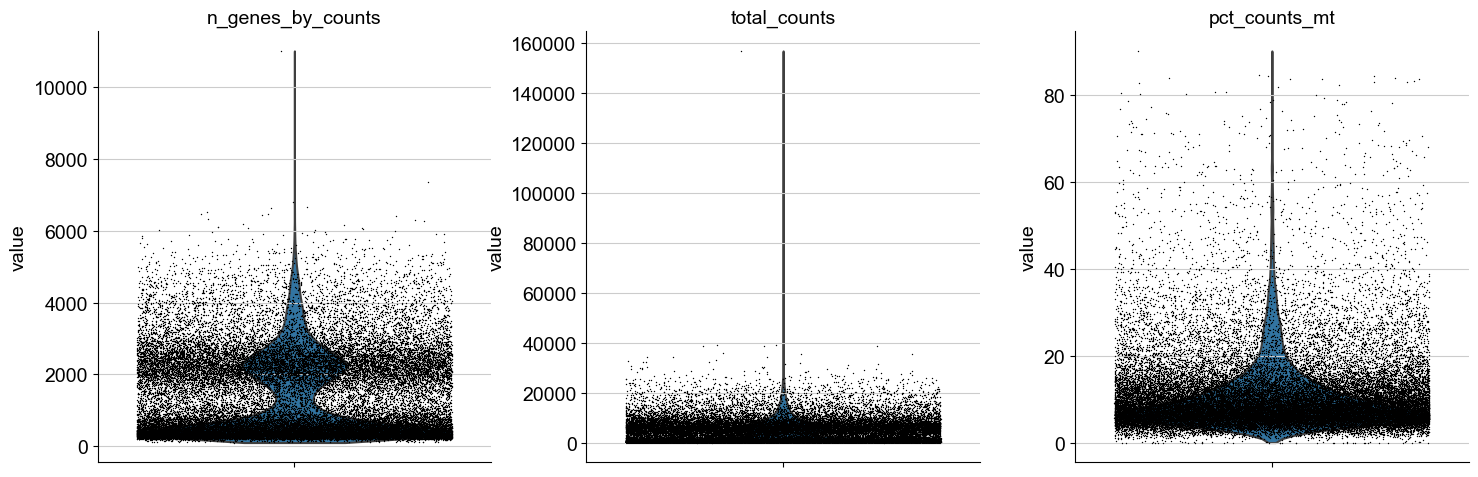

In [87]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")  # "MT-" for human, "Mt-" for mouse
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(p)]"))

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True, save = 'quality_cutoff_counts')
#sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#Filter out low quality
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X
Var_counts=adata.var
Var_counts.to_csv("uniform_alignments.csv")

In [88]:
sc.external.pp.scrublet(adata)

Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 3.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


In [89]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [90]:
# Save the annotated adata object to an .h5ad file
adata.write(os.path.join(dir_path, 'annotated_adata.h5ad'))

In [91]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data:
sc.pp.log1p(adata)

In [92]:
sc.tl.pca(adata)

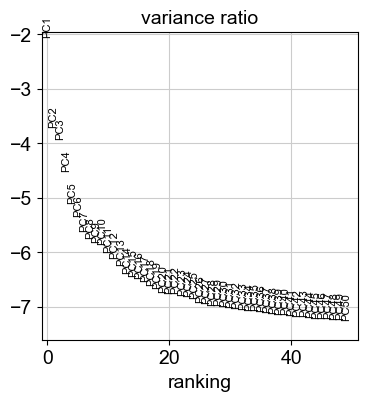

In [93]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, save='variance')

In [98]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

In [99]:
sc.tl.umap(adata)

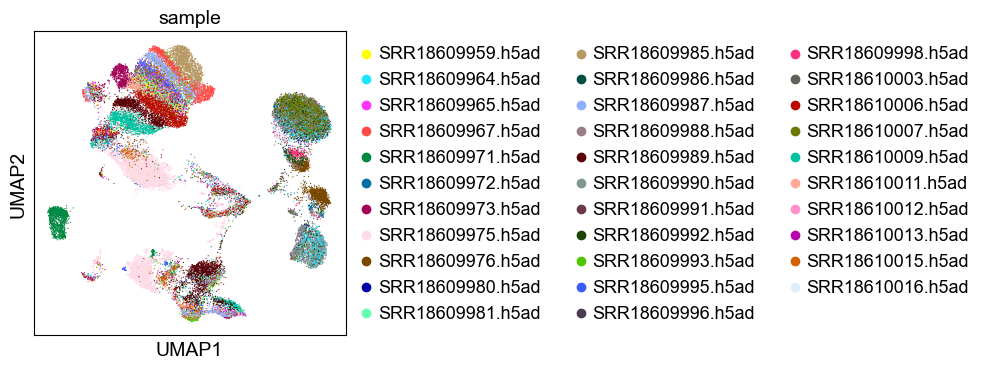

In [100]:
sc.pl.umap(adata, color="sample", save = "UMAP_all_samples")

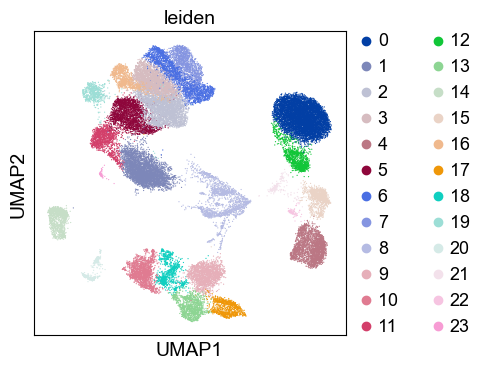

In [101]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=["leiden"], save="Umap_leiden_clusters")

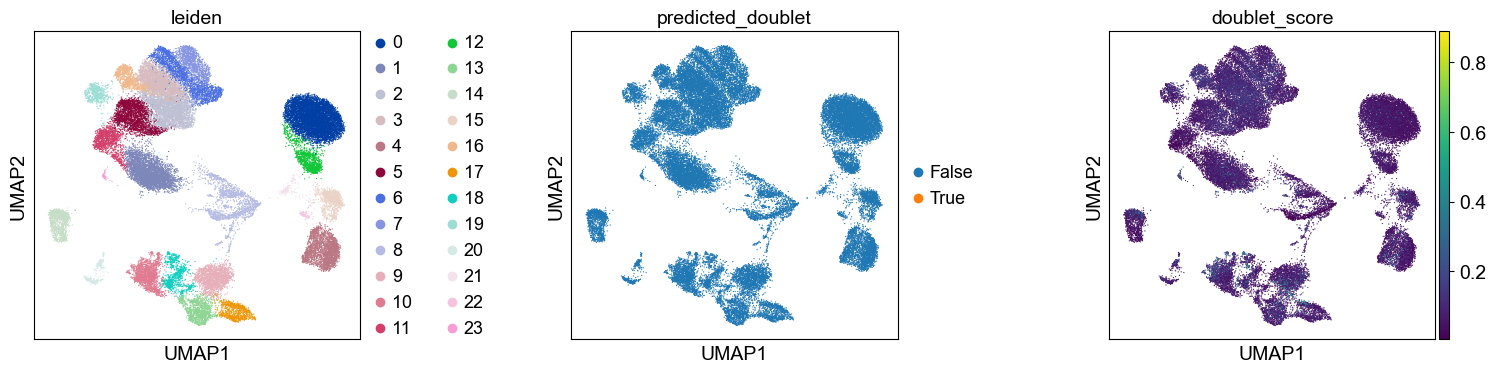

In [103]:
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    save = "Leiden_doublet_score_QC"
)


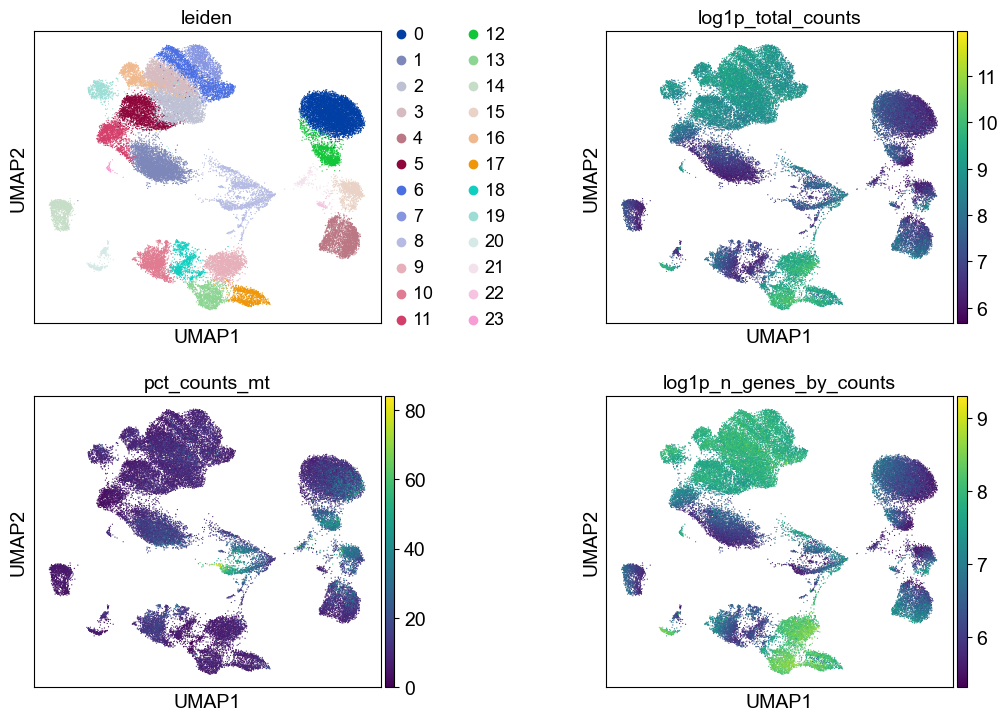

In [104]:
adata = adata[adata.obs["predicted_doublet"] == False].copy()
sc.pl.umap(
    adata, color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"], wspace=0.5, ncols=2,
    save = 'QC_overview'
)

In [105]:
sc.tl.leiden(adata, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, key_added="leiden_res0_1", resolution=0.1)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)


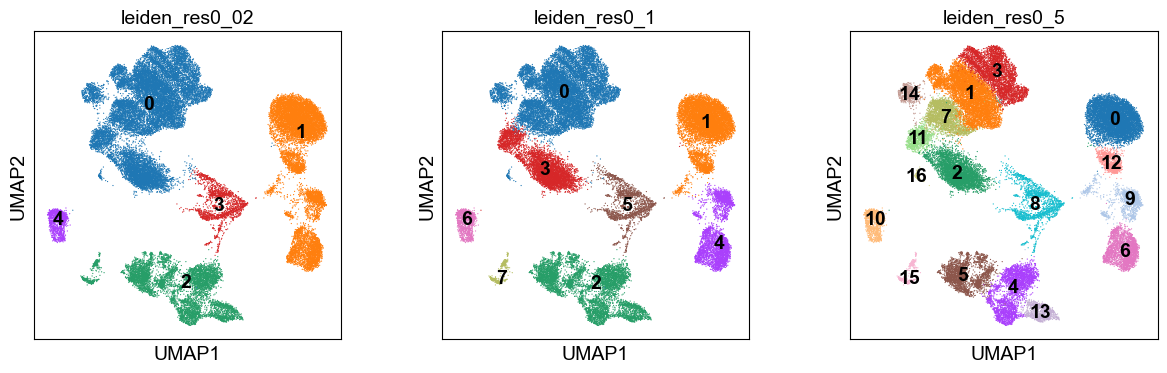

In [106]:
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_1", "leiden_res0_5"],
    legend_loc="on data",
    save = "leiden_resolutions"
)

2024-06-28 12:39:57,449 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-06-28 12:40:06,003 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-06-28 12:40:06,150 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2024-06-28 12:40:16,388 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2024-06-28 12:40:26,553 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2024-06-28 12:40:36,901 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2024-06-28 12:40:47,927 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2024-06-28 12:40:59,895 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2024-06-28 12:41:13,164 - harmonypy - INFO - Converged after 6 iterations
Converged after 6 iterations


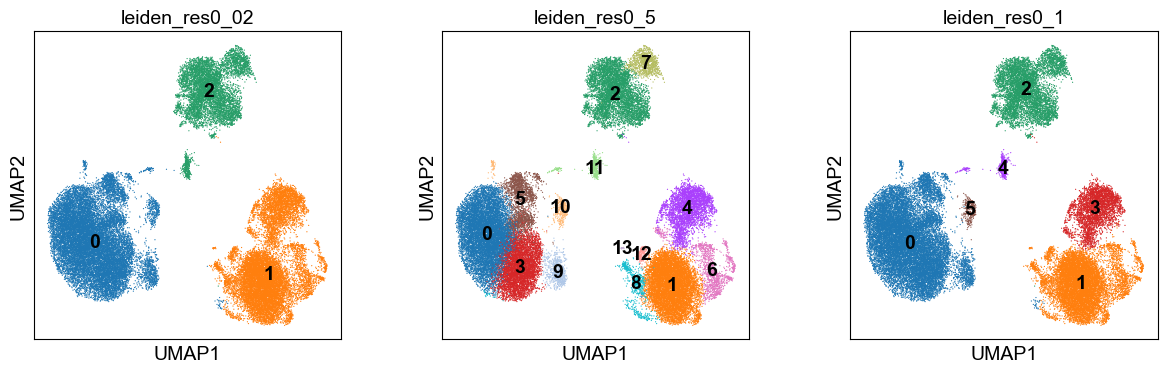

In [118]:
#Integration of data using harmony
sce.pp.harmony_integrate(adata, 'sample')
'X_pca_harmony' in adata.obsm
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, key_added="leiden_res0_1", resolution=0.1)

sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res0_1"],
    legend_loc="on data",
    save = "leiden_resolutions_harmony"
)

In [119]:
#Sample UMAP
sample_umap = sc.pl.umap(adata, color=['sample'],
    show=False, palette=sns.color_palette("husl", 4),
legend_fontsize=6, frameon=True, title='Sample_ID',save = "hamrony_umap_sample")

In [120]:
ct.models.download_models(model=["Immune_All_High.pkl"], force_update=True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 50
📂 Storing models in /Users/kiliankleemann/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Immune_All_High.pkl


In [121]:
model = ct.models.Model.load(model="Immune_All_High.pkl")
predictions = ct.annotate(adata, model="Immune_All_High.pkl", majority_voting=False, over_clustering="leiden_res0_02")
# convert back to anndata||
adata = predictions.to_adata()

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 39151 cells and 31670 genes
🔗 Matching reference genes in the model
🧬 5898 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


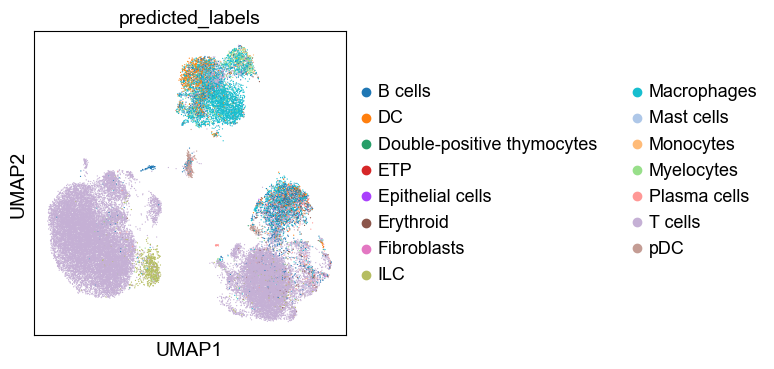

In [122]:
sc.pl.umap(adata, color=["predicted_labels"], ncols=1)

In [38]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource(name="PanglaoDB", organism="human")
# Keep canonical cell type markers alone
markers = markers[(markers["canonical_marker"] == "True")]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
markers.head()

dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True)

genesymbol canonical_marker                     cell_type germ_layer human  \
1      CTRB1             True                  Acinar cells   Endoderm  True   
2       KLK1             True             Endothelial cells   Mesoderm  True   
5       KLK1             True               Principal cells   Mesoderm  True   
6       KLK1             True                  Acinar cells   Endoderm  True   
7       KLK1             True  Plasmacytoid dendritic cells   Mesoderm  True   

  human_sensitivity human_specificity mouse mouse_sensitivity  \
1               1.0       0.000628931  True          0.957143   
2               0.0        0.00841969  True               0.0   
5               0.0        0.00814536  True          0.285714   
6          0.833333        0.00503145  True          0.314286   
7               0.0        0.00820189  True               1.0   

  mouse_specificity ncbi_tax_id          organ ubiquitiousness  
1         0.0159201        9606       Pancreas           0.017  
2         0.0149153        9606    Vasculature           0.013  
5         0.0140583        9606         Kidney           0.013  
6         0.0128263        9606       Pancreas           0.013  
7         0.0129136        9606  Immune system           0.013

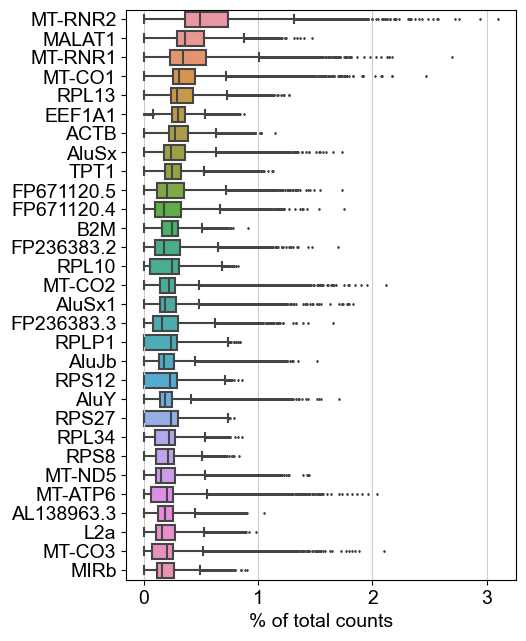

In [124]:
sc.pl.highest_expr_genes(adata, n_top=30,save="highest_expressed")


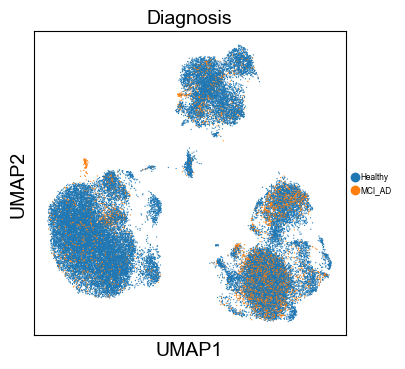

In [125]:
#make UMAP per diagnosis
adata.obs.groupby(["Diagnosis"]).apply(len)
sc.pl.umap(
    adata,
    color=["Diagnosis"],
    save = "condition_umap_harmony",legend_fontsize=6, frameon=True, wspace=0.5
)

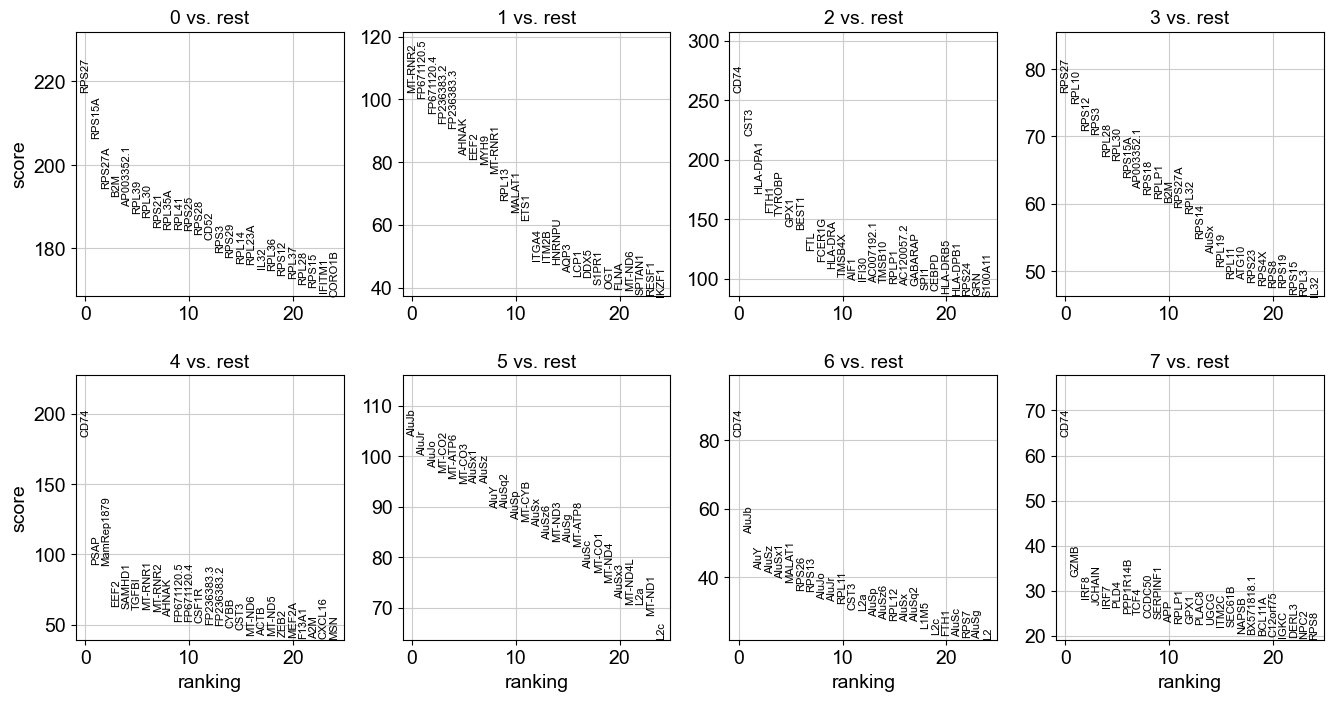

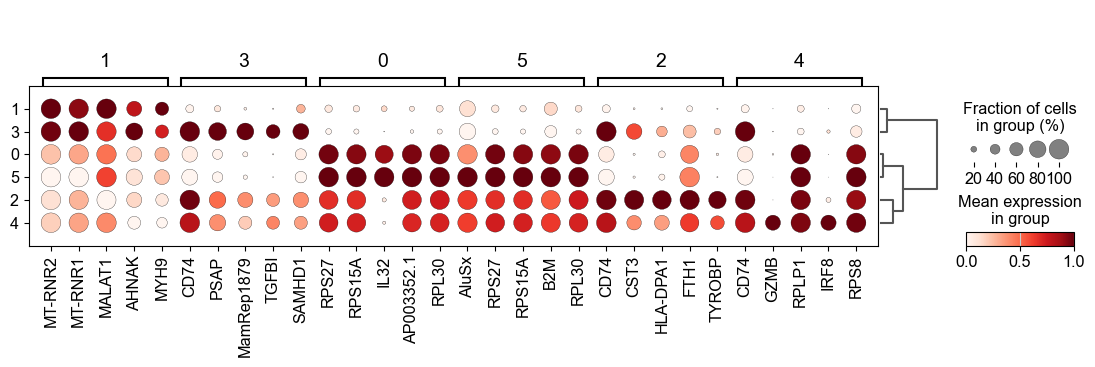

In [129]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.tl.rank_genes_groups(adata, groupby="leiden_res0_1")

# Filter those
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1.5)
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res0_1", standard_scale="var", n_genes=5, save='marker_genes_leiden01')

In [130]:
# Save the results
results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names
marker_genes_df = pd.DataFrame(
    {group + '_' + key: results[key][group]
     for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

# Save the DataFrame to a CSV file
marker_genes_df.to_csv('marker_genes_per_cluster.csv')

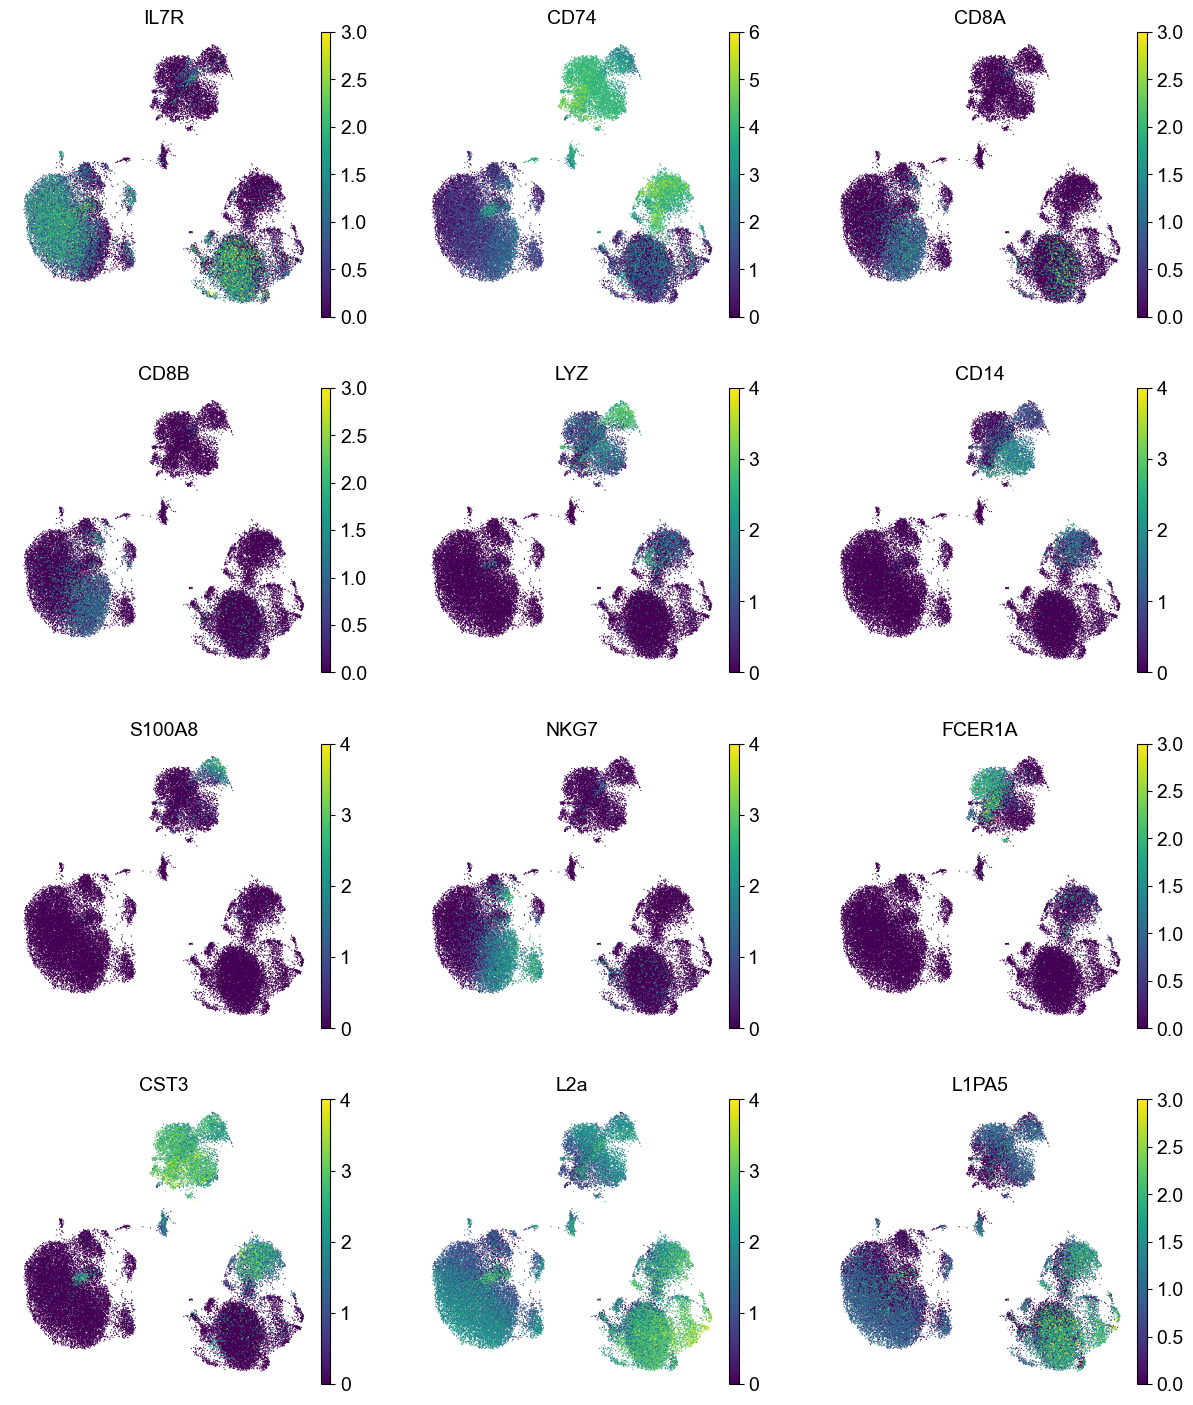

In [157]:
Marker_gene_label = ["IL7R", "CD74", "CD8A", "CD8B", "LYZ", "CD14","S100A8", 
                      "NKG7", "FCER1A", "CST3", "L2a", "L1PA5" ]

sc.pl.umap(adata, color=[*Marker_gene_label], legend_loc="on data", frameon=False, ncols=3, save='marker_geness' )

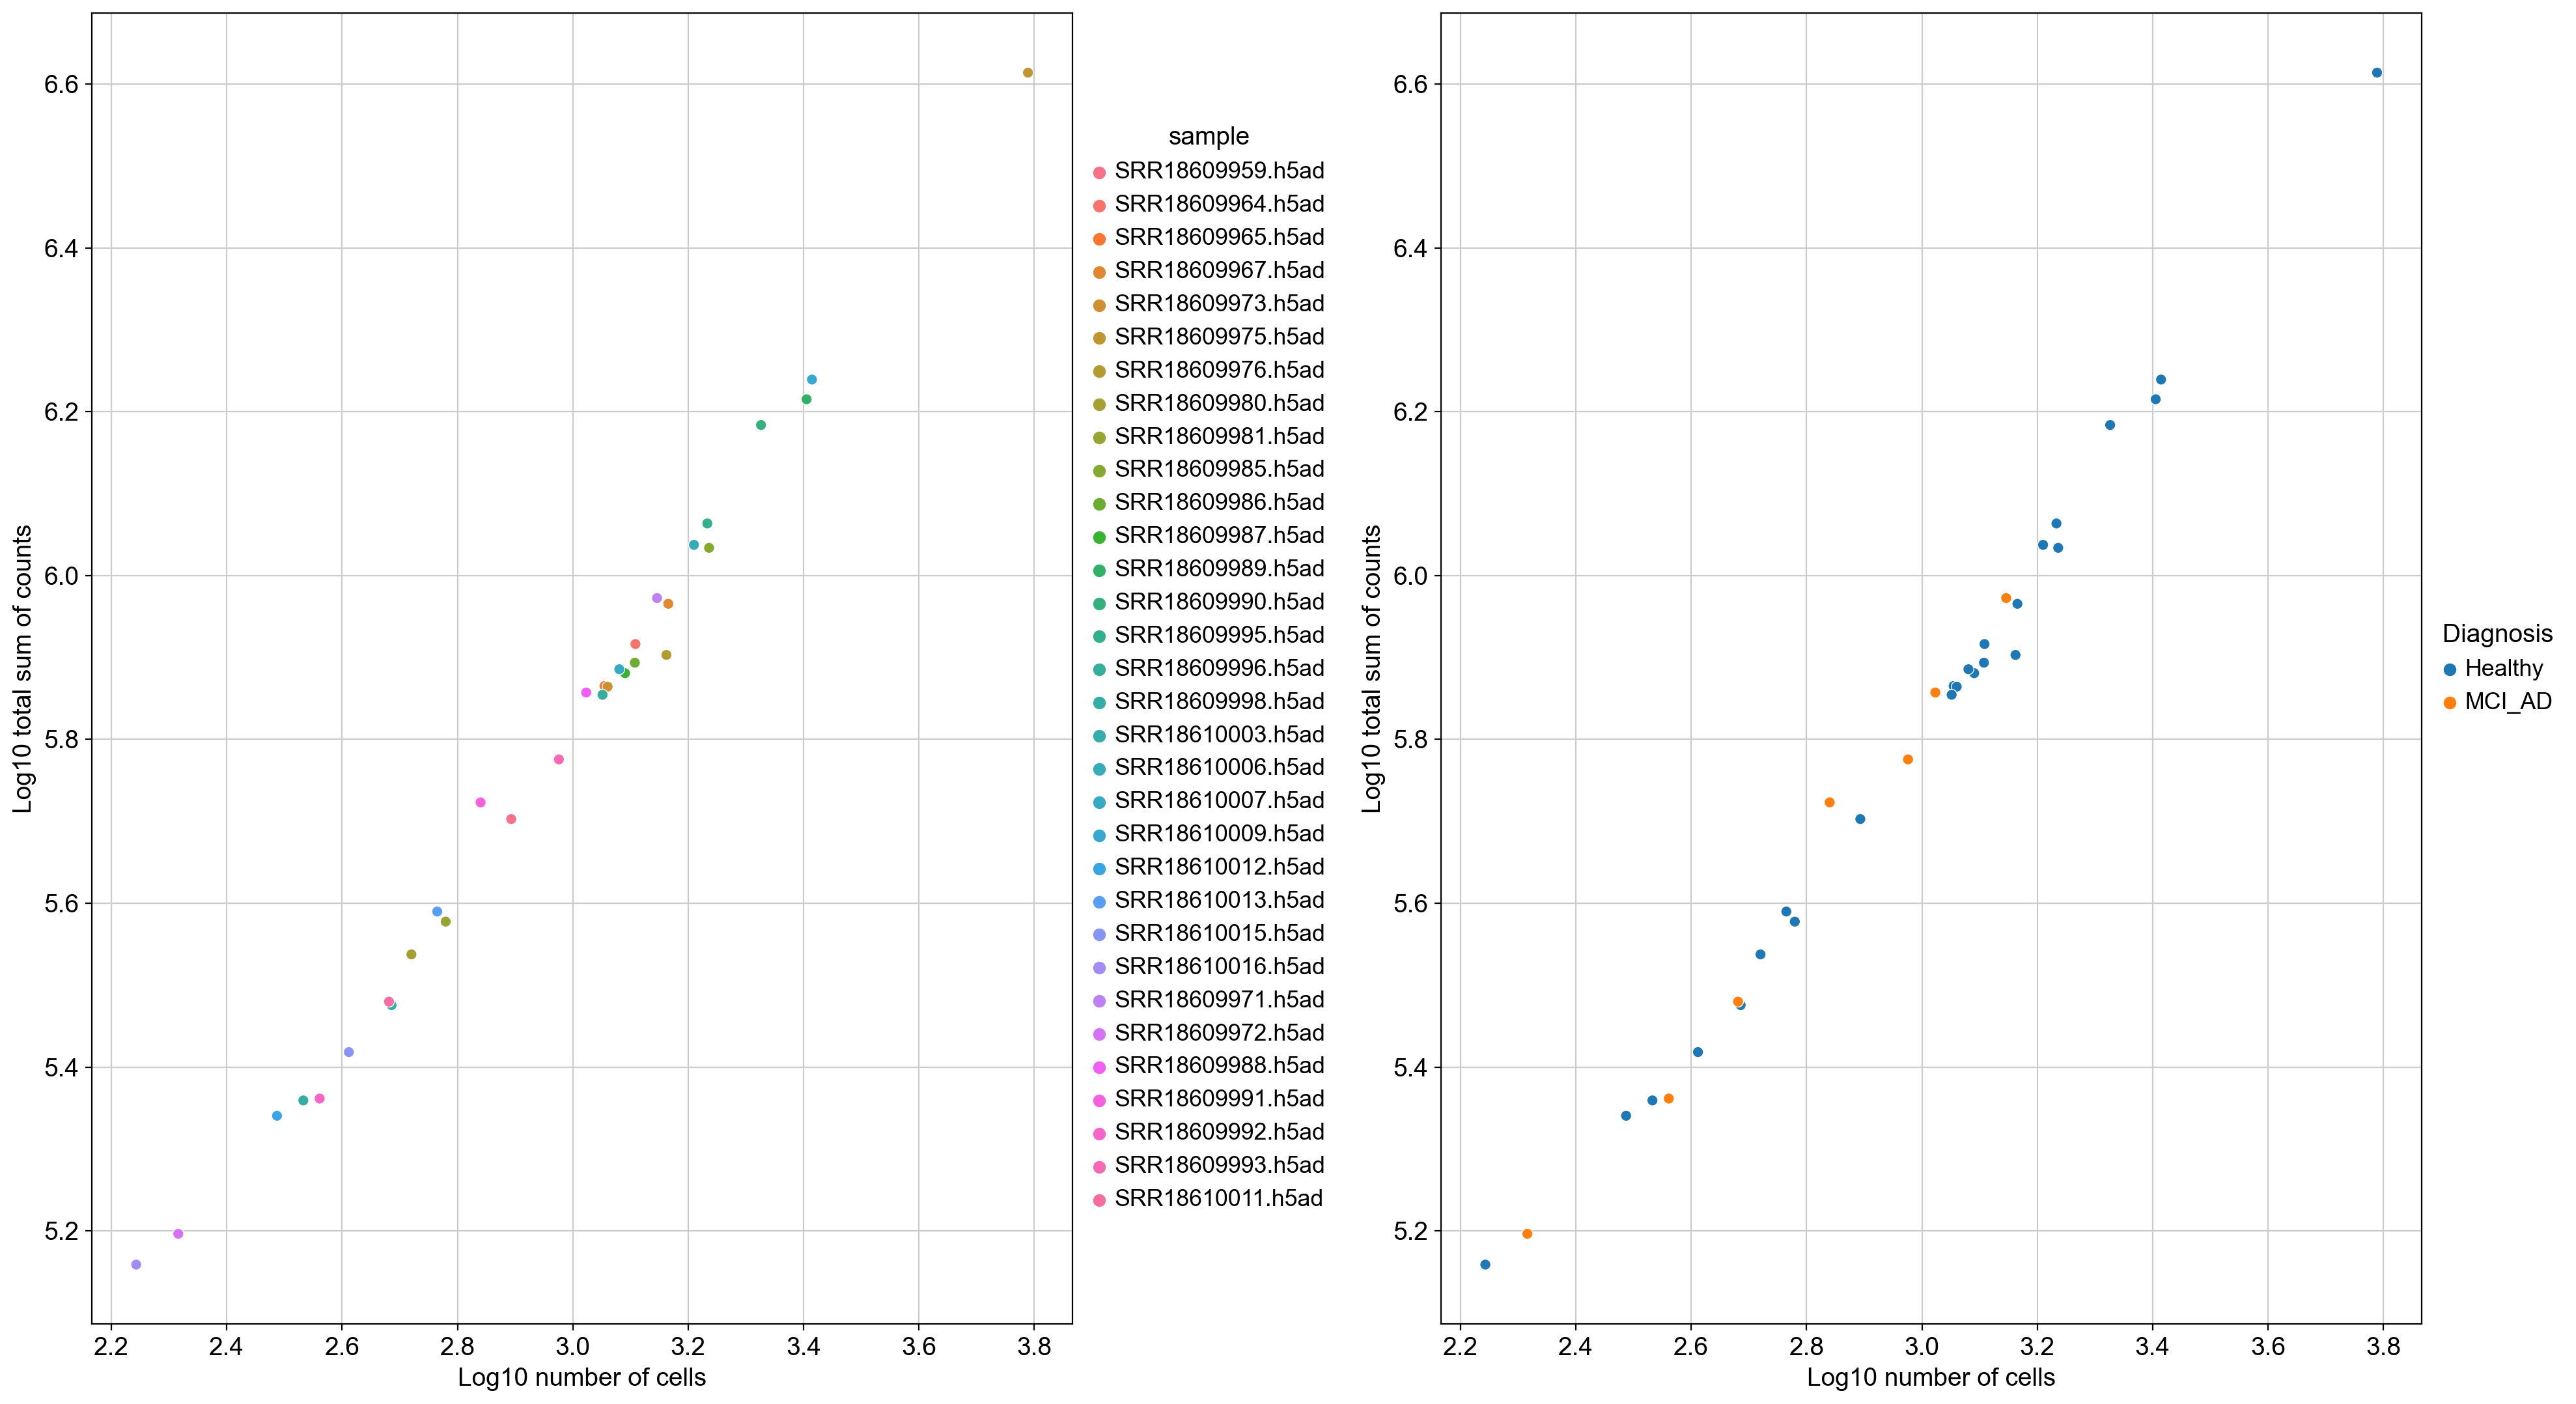

In [154]:
#Pseudobulk analysis
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample',
    groups_col='Diagnosis',
    layer='counts',
    mode='sum',
    min_cells=5,
    min_counts=300
)
dc.plot_psbulk_samples(pdata, groupby=['sample','Diagnosis'], figsize=(20, 11), save='PCA_pseudobulk')

In [158]:
#DEGs of pseudobulk
dds = DeseqDataSet(
    adata=pdata,
    design_factors='Diagnosis',
    ref_level=['Diagnosis', 'Healthy'],
    refit_cooks=False,
    n_cpus=8)
# Compute LFCs
dds.deseq2()
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(dds, contrast=["Diagnosis", 'MCI-AD', 'Healthy'], n_cpus=8)
# Compute Wald test
stat_res.summary()
# Shrink LFCs
stat_res.lfc_shrink(coeff='Diagnosis_MCI-AD_vs_Healthy')
# Extract results
results_df = stat_res.results_df
results_df

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 11.43 seconds.

Fitting dispersion trend curve...
... done in 3.26 seconds.

Fitting MAP dispersions...
... done in 8.86 seconds.

Fitting LFCs...
... done in 2.12 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 0.79 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n     0.427541        1.154703  1.477302  0.781630  0.434432  0.999999
(GAATG)n     0.144429        0.843996  2.163690  0.390072  0.696483  0.999999
A1BG        15.903933       -0.086681  0.712417 -0.121672  0.903159  0.999999
A1BG-AS1     2.668866       -0.452949  0.569741 -0.795009  0.426608  0.999999
A1CF         0.072083        0.698894  3.242799  0.215522  0.829360  0.999999
...               ...             ...       ...       ...       ...       ...
ZZEF1       36.539852        0.229731  0.282869  0.812145  0.416708  0.999999
Zaphod       8.111534        0.520371  0.233611  2.227514  0.025913  0.999999
Zaphod2      2.571134        0.728653  0.344220  2.116824  0.034275  0.999999
Zaphod3      3.640204        0.306246  0.298201  1.026976  0.304432  0.999999
hAT-N1_Mam   2.644223        0.108204  0.553353  0.195543  0.844968  0.999999

[29082 rows x 6 columns]

Fitting MAP LFCs...
/Users/kiliankleemann/anaconda3/lib/python3.11/site-packages/pydeseq2/utils.py:1220: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/Users/kiliankleemann/anaconda3/lib/python3.11/site-packages/pydeseq2/utils.py:1220: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/Users/kiliankleemann/anaconda3/lib/python3.11/site-packages/pydeseq2/utils.py:1220: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Shrunk log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 3.33 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n     0.427541        0.001009  0.046690  0.781630  0.434432  0.999999
(GAATG)n     0.144429        0.000381  0.047849  0.390072  0.696483  0.999999
A1BG        15.903933       -0.000245  0.043195 -0.121672  0.903159  0.999999
A1BG-AS1     2.668866       -0.002072  0.042310 -0.795009  0.426608  0.999999
A1CF         0.072083        0.000211  0.048450  0.215522  0.829360  0.999999
...               ...             ...       ...       ...       ...       ...
ZZEF1       36.539852        0.004307  0.043789  0.812145  0.416708  0.999999
Zaphod       8.111534        0.014228  0.046707  2.227514  0.025913  0.999999
Zaphod2      2.571134        0.008505  0.043805  2.116824  0.034275  0.999999
Zaphod3      3.640204        0.004814  0.042265  1.026976  0.304432  0.999999
hAT-N1_Mam   2.644223        0.000558  0.043368  0.195543  0.844968  0.999999

[29082 rows x 6 columns]

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n     0.427541        0.001009  0.046690  0.781630  0.434432  0.999999
(GAATG)n     0.144429        0.000381  0.047849  0.390072  0.696483  0.999999
A1BG        15.903933       -0.000245  0.043195 -0.121672  0.903159  0.999999
A1BG-AS1     2.668866       -0.002072  0.042310 -0.795009  0.426608  0.999999
A1CF         0.072083        0.000211  0.048450  0.215522  0.829360  0.999999
...               ...             ...       ...       ...       ...       ...
ZZEF1       36.539852        0.004307  0.043789  0.812145  0.416708  0.999999
Zaphod       8.111534        0.014228  0.046707  2.227514  0.025913  0.999999
Zaphod2      2.571134        0.008505  0.043805  2.116824  0.034275  0.999999
Zaphod3      3.640204        0.004814  0.042265  1.026976  0.304432  0.999999
hAT-N1_Mam   2.644223        0.000558  0.043368  0.195543  0.844968  0.999999

[29082 rows x 6 columns]

In [68]:
#results_df.to_csv("results_MCI-AD_vs_Healthy_all_samples.csv")

In [159]:
results_sig_padj_df = results_df[results_df['padj'] < 0.05]
results_sig_pval_df = results_df[results_df['pvalue'] < 0.05]

In [71]:
results_sig_padj_df.to_csv("results_sig_padj_MCI-AD_vs_Healthy_all_samples.csv")

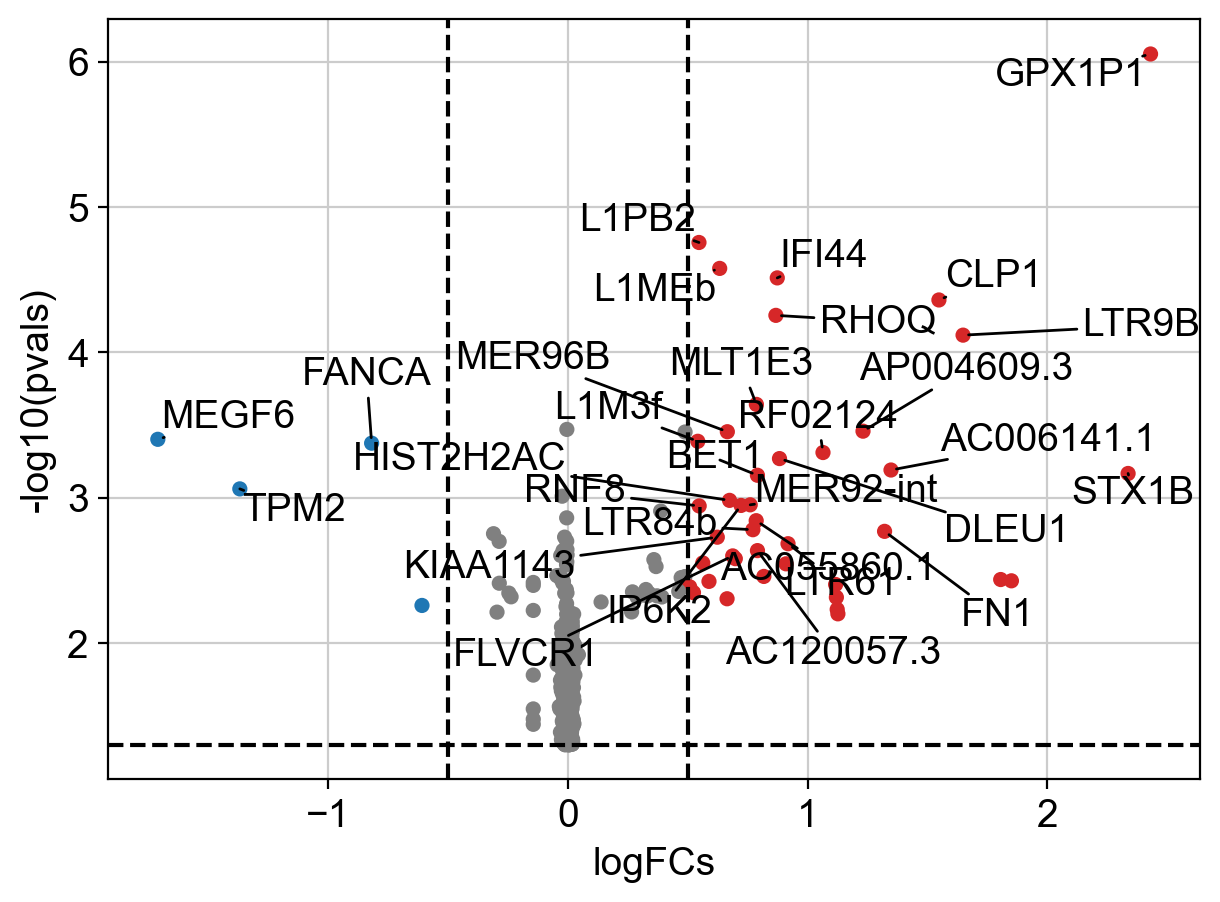

In [160]:
dc.plot_volcano_df(results_sig_pval_df, x='log2FoldChange', y='pvalue', top=30, save='volcano_top_30_MCI-AD_vs_Healthy_all_samples')

       gene   baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
0  (CATTC)n   0.040209        0.001036  0.128308  0.248156  0.804014  0.99988
1  (GAATG)n   0.044510        0.001871  0.154784  0.318889  0.749811  0.99988
2      A1BG   1.541918       -0.016946  0.104451 -1.831990  0.066953  0.99988
3  A1BG-AS1   0.686272        0.002290  0.111107  0.557776  0.576997  0.99988
4       A2M  85.664460        0.009047  0.110290  0.405122  0.685388  0.99988


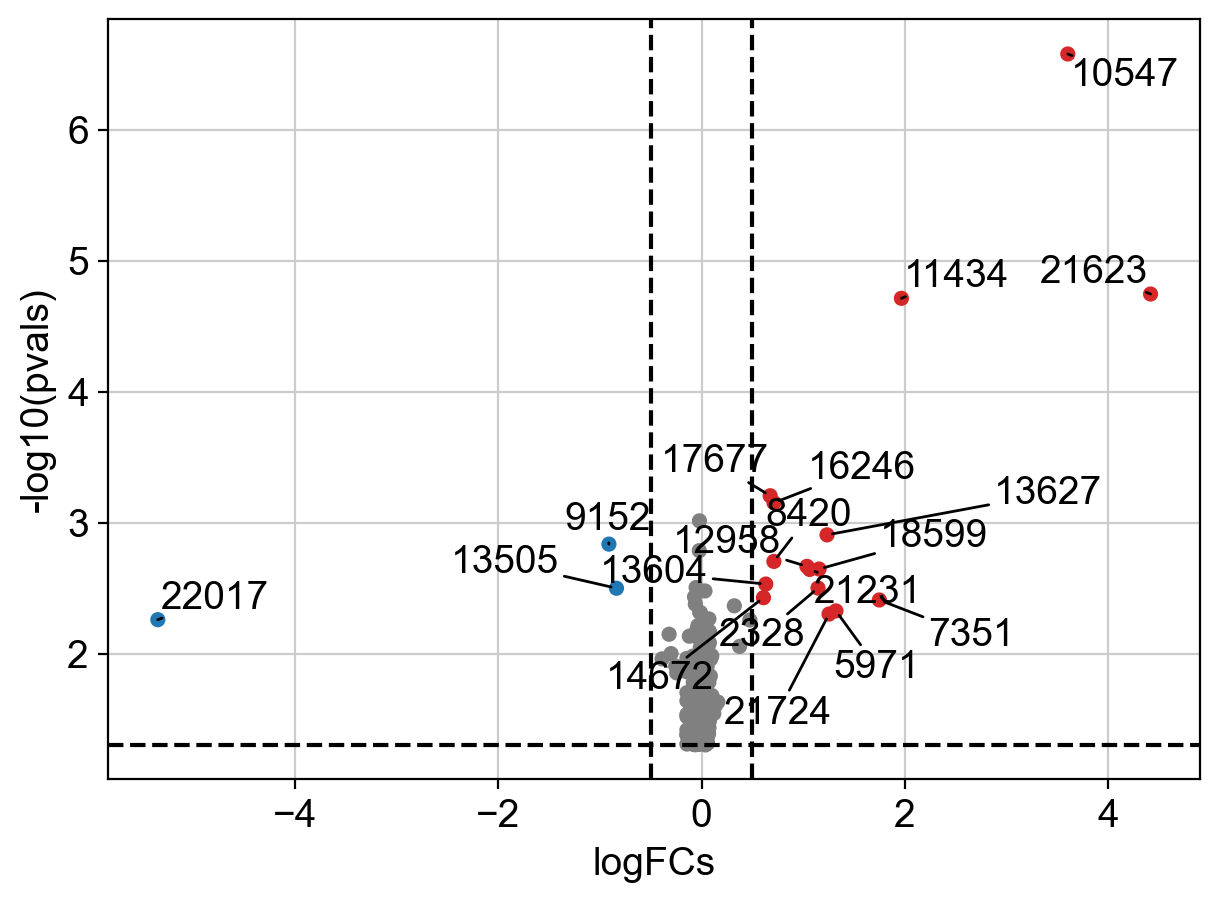

In [152]:
# Load the CSV file into a DataFrame
res_data = pd.read_csv("DEG_results_AD-MCI_vs_Healthy_per_cluster/adata_cluster_3_Diagnosis_MCI-AD_vs_Healthy_results.csv")

first_column_name = res_data.columns[0]
res_data.rename(columns={first_column_name: 'gene'}, inplace=True)

# Display the first few rows of the DataFrame
print(res_data.head())
results_sig_pval_df = res_data[res_data['pvalue'] < 0.05]

results_sig_pval_df
dc.plot_volcano_df(results_sig_pval_df, x='log2FoldChange', y='pvalue', top=30, save='volcano_top_30_KO_vs_WT')

In [136]:
#Pseudobulk data per cluster
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample',
    groups_col='Diagnosis',
    layer='counts',
    mode='sum',
    min_cells=5,
    min_counts=300
)
pdata

AnnData object with n_obs × n_vars = 32 × 31670
    obs: 'sample', 'Sex', 'Diagnosis', 'Age', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'psbulk_props'

In [137]:
# Create a dictionary to store subsets
adata_subsets = {}

# Check if 'condition' column is present in the original adata
if 'Diagnosis' in adata.obs.columns:
    # Loop through clusters 0 to 17
    for cluster_label in range(18):  # Assumes clusters are labeled from 0 to 17
        cluster_label_str = str(cluster_label)
        
        # Check if the cluster label exists in the 'leiden' column
        if cluster_label_str in adata.obs['leiden_res0_1'].unique():
            subset_name = f'adata_cluster_{cluster_label_str}'
            
            # Create a copy of the subset with 'condition' information
            adata_subset = adata[adata.obs['leiden_res0_1'].isin([cluster_label_str])].copy()
            
            # Check if 'condition' column is present in the subset
            if 'Diagnosis' in adata_subset.obs.columns:
                adata_subsets[subset_name] = adata_subset
            else:
                print(f"Warning: 'condition' column not found in {subset_name}. Subset skipped.")
    
    # Access the subsets as needed
    for subset_name, subset in adata_subsets.items():
        print(f"{subset_name}:")
        print(subset)
        print("\n")
else:
    print("Error: 'condition' column not found in the original adata.")


adata_cluster_0:
AnnData object with n_obs × n_vars = 17743 × 31670
    obs: 'sample', 'Sex', 'Diagnosis', 'Age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res0_02', 'leiden_res0_1', 'leiden_res0_5', 'predicted_labels', 'conf_score'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'predicted_doublet_colors', 'predicted_labels_colors', 'Diagnosis_colors', 'rank_genes_groups', 'ran

In [138]:
#make directory for deg results
results_directory = "DEG_results_AD-MCI_vs_Healthy_per_cluster"
os.makedirs(results_directory, exist_ok=True)

# Loop through subsets
for subset_name, subset in adata_subsets.items():
    
    # Perform differential expression analysis using decoupler
    pdata = dc.get_pseudobulk(
    subset,
    sample_col='sample',
    groups_col='Diagnosis',
    layer='counts',
    mode='sum',
    min_cells=5,
    min_counts=300
    )

    dds = DeseqDataSet(
    adata=pdata,
    design_factors='Diagnosis',
    ref_level=['Diagnosis', 'Healthy'],
    refit_cooks=True,
    n_cpus=8,
    )

    # Compute LFCs
    dds.deseq2()

    # Extract contrast between KO vs normal
    stat_res = DeseqStats(dds, contrast=["Diagnosis", 'MCI-AD', 'Healthy'], n_cpus=8)

    # Compute Wald test
    stat_res.summary()
    
    stat_res.lfc_shrink(coeff='Diagnosis_MCI-AD_vs_Healthy')
    
    # Extract results
    results_df = stat_res.results_df

# Access differential expression results for each subset as needed
    csv_filename = os.path.join(results_directory, f"{subset_name}_Diagnosis_MCI-AD_vs_Healthy_results.csv")
    results_df.to_csv(csv_filename)

print(f"Differential expression results for {subset_name} saved to {csv_filename}")



Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 13.98 seconds.

Fitting dispersion trend curve...
... done in 3.13 seconds.

Fitting MAP dispersions...
... done in 11.31 seconds.

Fitting LFCs...
... done in 2.54 seconds.

Refitting 58 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 0.82 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n      1.771377        1.036227  0.889680  1.164719  0.244133  0.833385
(GAATG)n      0.046825        2.445295  3.836160  0.637433  0.523843  0.833385
A1BG        114.761269       -0.040275  0.184434 -0.218369  0.827142  0.934609
A1BG-AS1     16.179966        0.093179  0.273421  0.340788  0.733263  0.893846
A1CF          0.143729        2.046647  2.683342  0.762723  0.445629  0.833385
...                ...             ...       ...       ...       ...       ...
ZZEF1        87.514229        0.303808  0.143327  2.119685  0.034033  0.822310
Zaphod       21.098356        0.209938  0.216596  0.969259  0.332416  0.833385
Zaphod2       6.016210        0.503788  0.399091  1.262338  0.206827  0.833385
Zaphod3      14.186899        0.365445  0.323851  1.128436  0.259136  0.833385
hAT-N1_Mam    9.079685        0.042332  0.348717  0.121395  0.903378  0.965248

[29855 rows x 6 columns]

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 3.13 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n      1.771377        0.004546  0.080896  1.164719  0.244133  0.833385
(GAATG)n      0.046825       -0.000275  0.076546  0.637433  0.523843  0.833385
A1BG        114.761269       -0.005459  0.073833 -0.218369  0.827142  0.934609
A1BG-AS1     16.179966        0.005466  0.075435  0.340788  0.733263  0.893846
A1CF          0.143729       -0.000683  0.076268  0.762723  0.445629  0.833385
...                ...             ...       ...       ...       ...       ...
ZZEF1        87.514229        0.105049  0.145414  2.119685  0.034033  0.822310
Zaphod       21.098356        0.020706  0.077194  0.969259  0.332416  0.833385
Zaphod2       6.016210        0.013314  0.078368  1.262338  0.206827  0.833385
Zaphod3      14.186899        0.016831  0.080113  1.128436  0.259136  0.833385
hAT-N1_Mam    9.079685        0.000347  0.075629  0.121395  0.903378  0.965248

[29855 rows x 6 columns]

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 10.74 seconds.

Fitting dispersion trend curve...
... done in 3.34 seconds.

Fitting MAP dispersions...
... done in 7.93 seconds.

Fitting LFCs...
... done in 2.34 seconds.

Refitting 153 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 0.83 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n     0.177932        1.155229  1.738829  0.664372  0.506452  0.999978
(GAATG)n     0.148217        0.301401  3.733649  0.080726  0.935660  0.999978
A1BG         1.157202       -0.021226  0.874877 -0.024261  0.980644  0.999978
A1BG-AS1     1.699354       -1.362188  0.752582 -1.810021  0.070293  0.999978
A1CF         0.144133        0.301401  3.733649  0.080726  0.935660  0.999978
...               ...             ...       ...       ...       ...       ...
ZZEF1       22.187216        0.175195  0.239500  0.731500  0.464474  0.999978
Zaphod       8.829863       -0.393115  0.533102 -0.737410  0.460873  0.999978
Zaphod2      2.444798        0.161502  0.576643  0.280073  0.779421  0.999978
Zaphod3      4.382846       -0.620086  0.596500 -1.039541  0.298553  0.999978
hAT-N1_Mam   3.484582       -0.165750  0.676122 -0.245148  0.806341  0.999978

[27470 rows x 6 columns]

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 3.04 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n     0.177932        0.015901  0.187312  0.664372  0.506452  0.999978
(GAATG)n     0.148217       -0.000207  0.169450  0.080726  0.935660  0.999978
A1BG         1.157202        0.000191  0.162536 -0.024261  0.980644  0.999978
A1BG-AS1     1.699354       -0.061435  0.175301 -1.810021  0.070293  0.999978
A1CF         0.144133        0.002468  0.184513  0.080726  0.935660  0.999978
...               ...             ...       ...       ...       ...       ...
ZZEF1       22.187216        0.049972  0.143795  0.731500  0.464474  0.999978
Zaphod       8.829863       -0.025471  0.159248 -0.737410  0.460873  0.999978
Zaphod2      2.444798        0.008866  0.159058  0.280073  0.779421  0.999978
Zaphod3      4.382846       -0.032707  0.161390 -1.039541  0.298553  0.999978
hAT-N1_Mam   3.484582       -0.007113  0.161430 -0.245148  0.806341  0.999978

[27470 rows x 6 columns]

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 16.23 seconds.

Fitting dispersion trend curve...
... done in 3.92 seconds.

Fitting MAP dispersions...
... done in 12.88 seconds.

Fitting LFCs...
... done in 2.28 seconds.

Refitting 44 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 0.96 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
(CATTC)n      0.634325        0.464766  1.194140  0.389206  0.697124  0.99993
(GAATG)n      0.104565       -0.560271  3.832285 -0.146198  0.883765  0.99993
A1BG         58.137596       -0.207464  0.284300 -0.729735  0.465552  0.99993
A1BG-AS1      7.448482       -0.523853  0.430610 -1.216538  0.223780  0.99993
A2M         401.082825        0.526765  0.285893  1.842524  0.065399  0.99993
...                ...             ...       ...       ...       ...      ...
ZZEF1        40.260357        0.126947  0.202271  0.627610  0.530260  0.99993
Zaphod       21.238474        0.253442  0.202455  1.251841  0.210628  0.99993
Zaphod2       4.842865       -0.177134  0.431570 -0.410441  0.681482  0.99993
Zaphod3      10.614794       -0.506890  0.321948 -1.574448  0.115384  0.99993
hAT-N1_Mam    7.162358       -0.129407  0.287971 -0.449374  0.653162  0.99993

[29797 rows x 6 columns]

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 3.64 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
(CATTC)n      0.634325        0.004590  0.109720  0.389206  0.697124  0.99993
(GAATG)n      0.104565       -0.000954  0.099358 -0.146198  0.883765  0.99993
A1BG         58.137596       -0.021210  0.103160 -0.729735  0.465552  0.99993
A1BG-AS1      7.448482       -0.025327  0.106583 -1.216538  0.223780  0.99993
A2M         401.082825        0.071868  0.142320  1.842524  0.065399  0.99993
...                ...             ...       ...       ...       ...      ...
ZZEF1        40.260357        0.024497  0.098109  0.627610  0.530260  0.99993
Zaphod       21.238474        0.051957  0.110779  1.251841  0.210628  0.99993
Zaphod2       4.842865       -0.008075  0.102398 -0.410441  0.681482  0.99993
Zaphod3      10.614794       -0.046918  0.115696 -1.574448  0.115384  0.99993
hAT-N1_Mam    7.162358       -0.012629  0.098842 -0.449374  0.653162  0.99993

[29797 rows x 6 columns]

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.74 seconds.

Fitting dispersion trend curve...
... done in 2.79 seconds.

Fitting MAP dispersions...
... done in 7.00 seconds.

Fitting LFCs...
... done in 2.22 seconds.

Refitting 43 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 0.78 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
(CATTC)n     0.040209        0.892667  3.597200  0.248156  0.804014  0.99988
(GAATG)n     0.044510        1.141418  3.579360  0.318889  0.749811  0.99988
A1BG         1.541918       -2.387151  1.303037 -1.831990  0.066953  0.99988
A1BG-AS1     0.686272        0.667800  1.197254  0.557776  0.576997  0.99988
A2M         85.664459        0.167912  0.414472  0.405122  0.685388  0.99988
...               ...             ...       ...       ...       ...      ...
ZZEF1        8.220280       -0.220830  0.398871 -0.553638  0.579826  0.99988
Zaphod       3.195152        1.073489  0.467070  2.298347  0.021542  0.99988
Zaphod2      1.431676       -0.396044  0.900023 -0.440037  0.659910  0.99988
Zaphod3      1.704087        0.475593  0.711177  0.668741  0.503661  0.99988
hAT-N1_Mam   0.957527       -0.539342  1.134839 -0.475259  0.634603  0.99988

[23680 rows x 6 columns]

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 3.07 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
(CATTC)n     0.040209        0.001036  0.128308  0.248156  0.804014  0.99988
(GAATG)n     0.044510        0.001871  0.154784  0.318889  0.749811  0.99988
A1BG         1.541918       -0.016946  0.104451 -1.831990  0.066953  0.99988
A1BG-AS1     0.686272        0.002290  0.111107  0.557776  0.576997  0.99988
A2M         85.664459        0.009047  0.110290  0.405122  0.685388  0.99988
...               ...             ...       ...       ...       ...      ...
ZZEF1        8.220280       -0.012799  0.106547 -0.553638  0.579826  0.99988
Zaphod       3.195152        0.046368  0.129600  2.298347  0.021542  0.99988
Zaphod2      1.431676       -0.006052  0.107764 -0.440037  0.659910  0.99988
Zaphod3      1.704087        0.007792  0.111978  0.668741  0.503661  0.99988
hAT-N1_Mam   0.957527       -0.004918  0.105077 -0.475259  0.634603  0.99988

[23680 rows x 6 columns]

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.35 seconds.

Fitting dispersion trend curve...
... done in 3.68 seconds.

Fitting MAP dispersions...
... done in 6.36 seconds.

Fitting LFCs...
... done in 1.70 seconds.

Refitting 32 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 0.70 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n     0.052590        1.776373  5.157610  0.344418  0.730532       NaN
(GAATG)n     0.052230        1.805061  5.158719  0.349905  0.726410       NaN
A1BG        10.119543       -4.037953  2.287593 -1.765153  0.077538  0.946634
A1BG-AS1     0.569204        0.008424  2.577633  0.003268  0.997392       NaN
A2M          0.574397        4.214348  1.956428  2.154103  0.031232       NaN
...               ...             ...       ...       ...       ...       ...
ZZEF1        2.334753       -1.958852  2.345508 -0.835150  0.403633  0.946634
Zaphod       1.988596        1.382920  1.201346  1.151142  0.249674  0.946634
Zaphod2      2.351281        0.466043  1.057057  0.440887  0.659295  0.946634
Zaphod3      1.010357       -0.867160  2.286890 -0.379188  0.704549       NaN
hAT-N1_Mam   0.639467        0.001306  2.455173  0.000532  0.999575       NaN

[20835 rows x 6 columns]

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Diagnosis MCI-AD vs Healthy


... done in 2.23 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
(CATTC)n     0.052590       -0.002650  0.362240  0.344418  0.730532       NaN
(GAATG)n     0.052230       -0.002525  0.362635  0.349905  0.726410       NaN
A1BG        10.119543       -2.538008  2.084896 -1.765153  0.077538  0.946634
A1BG-AS1     0.569204       -0.026614  0.360371  0.003268  0.997392       NaN
A2M          0.574397        0.211146  0.506992  2.154103  0.031232       NaN
...               ...             ...       ...       ...       ...       ...
ZZEF1        2.334753       -0.108182  0.374038 -0.835150  0.403633  0.946634
Zaphod       1.988596        0.086009  0.369577  1.151142  0.249674  0.946634
Zaphod2      2.351281        0.042638  0.348364  0.440887  0.659295  0.946634
Zaphod3      1.010357       -0.062579  0.359983 -0.379188  0.704549       NaN
hAT-N1_Mam   0.639467       -0.029580  0.359572  0.000532  0.999575       NaN

[20835 rows x 6 columns]

ValueError: Factors should take at least two values, but Diagnosis takes the single value '['Healthy']'.